<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20ML%20SOM%20Self%20Organised%20Map%20-%20unsupervised%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn

#чёткие графики
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 6
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3


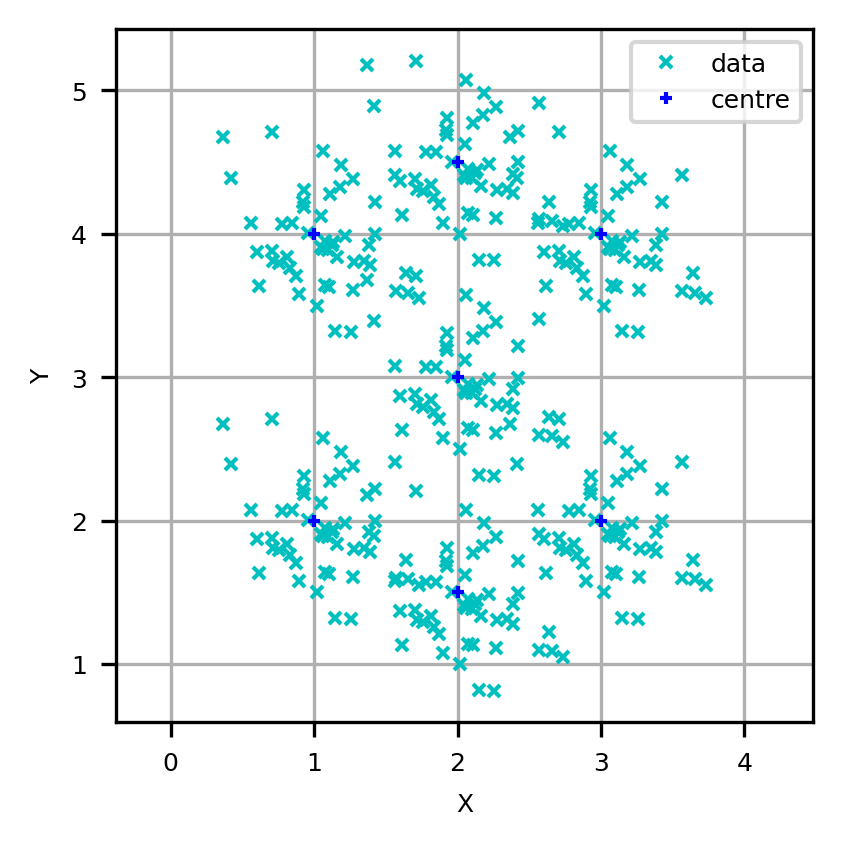

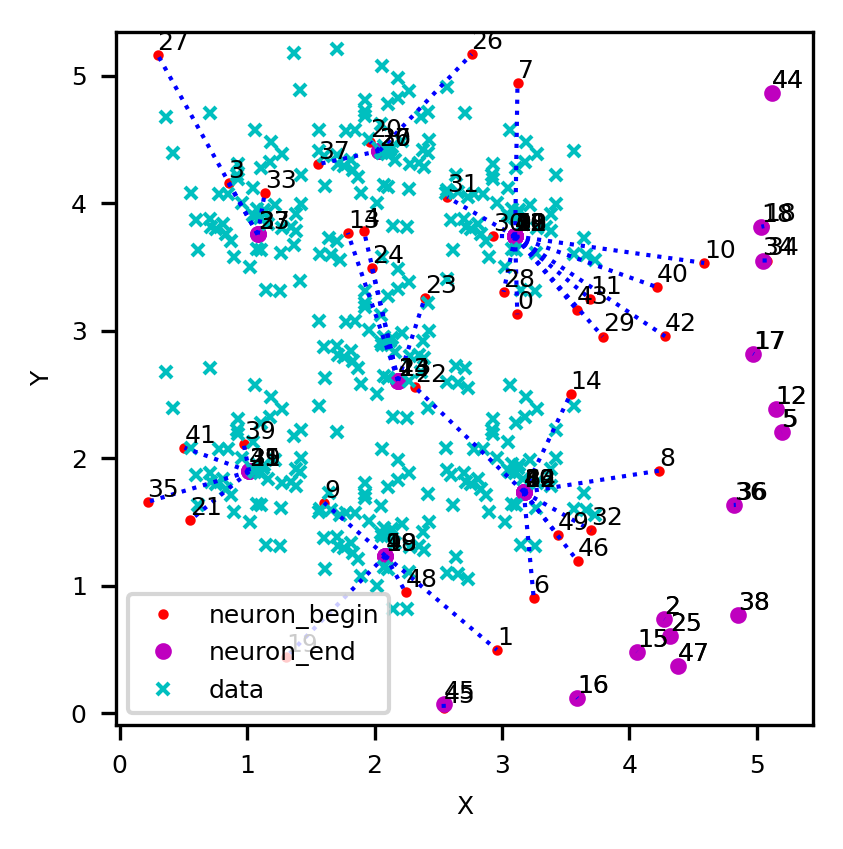

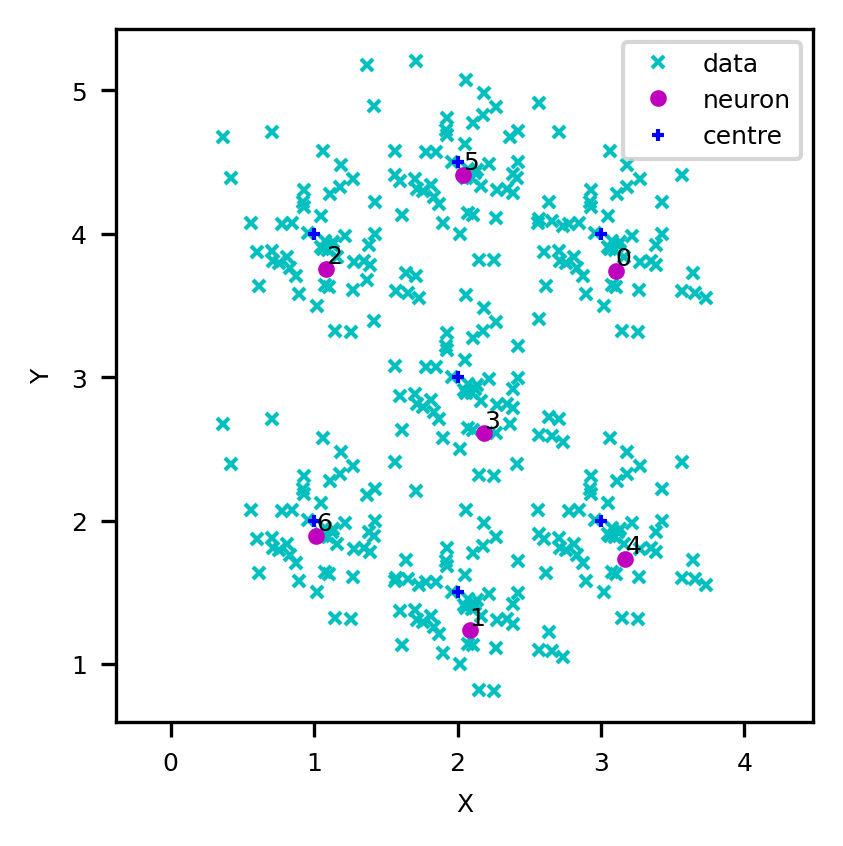

In [2]:


#программы нужные для построения SOM - одномерной карты Кохонена
class Nsom1:
    #документация
    '''работа с картой Кохонена'''
    #конструктор класса - входные данные число входов inputs и
    #число кластеров clusters; число входов - строка весов w(i)
    #число кластеров равно числу нейронов в столбце
    #krv - коэффициент радиуса влияния в долях border
    #vl - скорость обучения
    #l_m - постоянная замедления обучения
    #betta - постоянная уменьшения радиуса
    #инициализация весов случайная равномерная в n-мерном *кубе*
    #прямоугольнике (как сделать?) border с рёбрами от минимального до максимального
    #значения по каждой координате

    #подумать, что делать с радиусом влияния? он может быть сильно разный?


    def __init__(self,inputs,clusters,border,krv,vl,l_m,betta):
        #константы обучения сети в начале обучения
        self.v_learn0=vl#скорость >0, <1
        self.rad_v0=border*krv#радиус влияния 0.1...1
        #константы затухания: lam - постоянная замедления обучения,
        #bett - постоянная уменьшения радиуса
        self.lam=l_m#0.01
        self.bett=betta#0.01
        #матрица весов
        self.matrW=[]
        self.strW=[]
        for j in range(clusters):
            for i in range(inputs):
                self.strW.append(rn.uniform(border*0,border*1))
            self.matrW.append(self.strW)
            self.strW=[]
    #метод поиска нейрона-победителя в борьбе за вектор vec
    def find_win(self,vec):
        dist=[]
        for j in range(len(self.matrW)):
            dist.append(np.sqrt(sum(np.square(self.matrW[j] -
                                              np.array(vec)))))
        return(dist.index(min(dist)))
    #метод корректировки весов, v_learn = 0...1 это скорость обучения,
    #rad_v это радиус влияния нейрона, t - номер эпохи, lam - постоянная
    #замедления обучения, bett - постоянная уменьшения радиуса
    def corrW(self,ind_winner,vec,epoch):
        #считаем текущие скорость и радиус влияния
        v_learn=self.v_learn0*np.exp(-self.lam*epoch)
        rad_v=self.rad_v0*np.exp(-self.bett*epoch)
        #вектор расстояния между победителем и остальными узлами
        dist_win=[]
        for j in range(len(self.matrW)):
            hlp_sum=0
            for i in range(len(self.matrW[ind_winner])):
                hlp_sum=hlp_sum + np.square(self.matrW[j][i] -
                                                        self.matrW[ind_winner][i])
            dist_win.append(np.sqrt(hlp_sum))
        #считаем функцию расстояния до окрестности
        f_dist_win=[]
        for j in range(len(self.matrW)):
            f_dist_win.append(np.exp(-dist_win[j]*dist_win[j]/(2*rad_v*rad_v)))
        #считаем корректировку весов
        dW=[]
        for j in range(len(self.matrW)):
            dW.append(v_learn*f_dist_win[j]*(np.array(vec)-self.matrW[j]))

        return dW

#генерируем обучающее множество - это нужно делать перед
#заданием сети, чтобы задать границы квадрата, в котором
#выполняется начальное распределение нейронов
n=50 #число элементов обучающих подмножеств
#наборы случайных норм.распред. чисел
mu = 1.0
sigma = 0.33
rg1=[]
rg2=[]
data=[]

for ii in range(n):
    rg1.append(rn.normalvariate(mu, sigma))
    rg2.append(rn.normalvariate(mu, sigma))

for ii in range(n):
    data.append([rg1[ii],rg2[ii]+1])
    data.append([rg1[ii],rg2[ii]+3])
    data.append([rg1[ii]+1,rg2[ii]+0.5])
    data.append([rg1[ii]+1,rg2[ii]+2])
    data.append([rg1[ii]+1,rg2[ii]+3.5])
    data.append([rg1[ii]+2,rg2[ii]+1])
    data.append([rg1[ii]+2,rg2[ii]+3])

#идеальное число и центры кластеров,
#задаётся вручную по обучающему множеству
N_id = 7
C_id = [[1,2],[1,4],[2,1.5],[2,3],[2,4.5],[3,2],[3,4]]

#изображение обучающего множества

dataX=[]
dataY=[]
XC=[]
YC=[]
for sublist in data:
    dataX.append(sublist[0])
    dataY.append(sublist[1])
for sublist in C_id:
    XC.append(sublist[0])
    YC.append(sublist[1])

plt.plot(dataX,dataY,'xc',label='data')
plt.plot(XC,YC,'+b',label='centre')
plt.grid(True)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

#задаём параметры
krv = np.linspace(0.05,0.95,num=19)
vl = np.linspace(0.05,0.95,num=19)
l_m = np.linspace(0.001,0.011,num=11)
betta = np.linspace(0.001,0.011,num=11)

#вычисление стороны квадрата, накрывающего сеть
bSOM=max(max(np.abs(dataX)),max(np.abs(dataY)))


#делаем сеть
#эта строка для проверки найденных параметров
N_map=Nsom1(2,n,bSOM,0.06,0.35,0.002,0.0016)
#а эта работает с первыми заданными параметрами
#N_map=Nsom1(2,n,bSOM,krv[0],vl[0],l_m[0],betta[0])

#запоминаем исходные положения нейронов
netW_X=[]
netW_Y=[]
#эта конструкция выбирает первый [0] и второй [1] столбцы
for sublist in N_map.matrW:
    netW_X.append(sublist[0])
    netW_Y.append(sublist[1])
#сохраняем для истории начальное положение нейронов
oldW_X=netW_X
oldW_Y=netW_Y

#далее идёт обучение конкретной SOM
#циклы нужно делить на большие и малые
eras=range(20)
epochs=range(len(data))
for era in eras:
    for epoch in epochs:
        #вычисление коррекции
        ind_win=N_map.find_win(data[epoch])
        dw=N_map.corrW(ind_win,data[epoch],epoch)
        #обновление матрицы весов
        N_map.matrW=N_map.matrW+np.array(dw)
#изображение результата
netW_X=[]
netW_Y=[]
#эта конструкция выбирает первый [0] и второй [1] столбцы
for sublist in N_map.matrW:
    netW_X.append(sublist[0])
    netW_Y.append(sublist[1])

plt.plot(oldW_X,oldW_Y,'.r',label='neuron_begin')
plt.plot(netW_X,netW_Y,'om',label='neuron_end')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
#подпишем нейроны
for i in range(len(netW_X)):
    plt.annotate(str(i), (netW_X[i], netW_Y[i] + 0.04))
    plt.annotate(str(i), (oldW_X[i], oldW_Y[i] + 0.04))
#нарисуем данные
plt.plot(dataX,dataY,'xc',label='data')
#перемещения нейронов
plt.plot([netW_X,oldW_X],[netW_Y,oldW_Y],':b')
plt.legend()
plt.show()
#видно направление миграции в процессе обучения - от красной
#точки к фиолетовому кружку с одинаковой цифрой
#и с пустого или почти пустого места в зелёный лес
#это признаки рабочей нейронки. Некоторые нейроны так и не
#двинулись - в принципе тоже нормально

#теперь делаем статистическую обработку результатов

#задаём параметр близости в 1% от стороны квадрата bSOM
dmin=0.01*bSOM

#просматриваем все нейроны по очереди, убирая близкие
i=0
while i<(len(netW_X)-1):
    j=1
    while i+j<len(netW_X):
        if np.sqrt((netW_X[i]-netW_X[i+j])**2+(netW_Y[i]-netW_Y[i+j])**2)<dmin:
            del(netW_X[i+j])
            del(netW_Y[i+j])
        else:
            j=j+1
    i=i+1
#следующая операция - удаление всех нейронов вне прямоугольника, ограничивающего
#обучающее множество
Xmin=min(dataX)
Xmax=max(dataX)
Ymin=min(dataY)
Ymax=max(dataY)
i=0
while i<len(netW_X):
    if (netW_X[i]<Xmin or netW_X[i]>Xmax) or (netW_Y[i]<Ymin or netW_Y[i]>Ymax):
        del(netW_X[i])
        del(netW_Y[i])
    else:
        i=i+1
#график после удаления совпадающих нейронов
#нарисуем данные
plt.plot(dataX,dataY,'xc',label='data')
plt.plot(netW_X,netW_Y,'om',label='neuron')
plt.plot(XC,YC,'+b',label='centre')
#подпишем нейроны
for i in range(len(netW_X)):
    plt.annotate(str(i), (netW_X[i], netW_Y[i] + 0.04))

plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [3]:
#дальше нужно считать критерии
#первый - это отклонение числа оставшихся кластеров от заданного
#второй - это сумма минимальных расстояний от нейрона до идеального центра
#третий - логично взять комбинацию двух предыдущих

#первый
cl_num_err=len(netW_X)-N_id
print('превышено число кластеров на:')
print(cl_num_err)

#второй
#цикл для всех нейронов
sr2=0 #сумма квадратов расстояния
for i in range(len(netW_X)):
    #вложенный цикл поиска минимального расстояния до центра
    #начальное значение = расстоянию от нейрона до центра с индексом 0
    r2=(netW_X[i]-XC[0])**2+(netW_Y[i]-YC[0])**2
    for j in range(len(XC)):
        r2tmp=(netW_X[i]-XC[j])**2+(netW_Y[i]-YC[j])**2
        if r2tmp<=r2:
            r2=r2tmp
    sr2=sr2+r2
#здесь нормируем на максимальный размер области данных sr2<=1
#тогда критерий меньше 1? не факт, гарантия меньше числа центров
src=np.sqrt(sr2)/(len(XC)*max(max(dataX)-min(dataX),max(dataY)-min(dataY)))
print('относительное среднеквадратичное отклонение на заданный кластер:')
print(src)

#третий - самое простое сумма первых двух, т.к. второй меньше 1
#тогда целая часть с округлением вниз - отклонение числа нейронов
#дробная положительная часть относительное отклонение на нейрон
com_cr=cl_num_err+src
print('комплексный критерий:')
print(com_cr)

превышено число кластеров на:
0
относительное среднеквадратичное отклонение на заданный кластер:
0.0236904150090683
комплексный критерий:
0.0236904150090683
